<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_6/exp/main_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from sklearn.metrics import confusion_matrix

import sys
import os
util_files = '/content/drive/MyDrive/Colab_Notebooks/'
sys.path.append(os.path.abspath(util_files))

import model
import test 
import train
import testing

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
print("Layer Normalization model")
Layer_model = model.Layer().to(device)
summary(Layer_model, input_size=(1, 28, 28))

Layer Normalization model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         LayerNorm-3            [-1, 8, 26, 26]          10,816
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         LayerNorm-7           [-1, 16, 24, 24]          18,432
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        LayerNorm-13           [-1, 16, 10, 10]           3,200
          Dro

In [5]:
print("Batch Normalization model")
Batch_model = model.Batch().to(device)
summary(Batch_model, input_size=(1, 28, 28))

Batch Normalization model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dro

In [6]:
print("Group Normalization model")
Group_model = model.Group().to(device)
summary(Group_model, input_size=(1, 28, 28))

Group Normalization model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dro

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

In [8]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
optimizer = optim.SGD(Layer_model.parameters(), lr=0.015, momentum=0.7)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

print("training Layer Nornalization model")

for epoch in range(1, 21):
    layer_train_acc, layer_train_loss = train.Train.no_reg(Layer_model, device, train_loader, optimizer, epoch)
    layer_test_acc, layer_test_loss = testing.Test.test1(Layer_model, device, test_loader, epoch)
    scheduler.step()


  0%|          | 0/469 [00:00<?, ?it/s]

training Layer Nornalization model


Epoch1 : Loss=0.4346267879009247  Accuracy=85.09 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2324, Accuracy: 9551/10000 (95.51%)



Epoch2 : Loss=0.3522801399230957  Accuracy=91.34 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1189, Accuracy: 9764/10000 (97.64%)



Epoch3 : Loss=0.2299293428659439  Accuracy=93.20 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0973, Accuracy: 9776/10000 (97.76%)



Epoch4 : Loss=0.12790009379386902  Accuracy=94.34 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9855/10000 (98.55%)



Epoch5 : Loss=0.14432518184185028  Accuracy=95.08 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9856/10000 (98.56%)



Epoch6 : Loss=0.10868636518716812  Accuracy=95.71 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9891/10000 (98.91%)



Epoch7 : Loss=0.07620827108621597  Accuracy=96.03 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9848/10000 (98.48%)



Epoch8 : Loss=0.18529756367206573  Accuracy=96.38 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9886/10000 (98.86%)



Epoch9 : Loss=0.13955141603946686  Accuracy=96.59 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9893/10000 (98.93%)



Epoch10 : Loss=0.0872323215007782  Accuracy=96.71 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9901/10000 (99.01%)



Epoch11 : Loss=0.052799854427576065  Accuracy=96.87 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9898/10000 (98.98%)



Epoch12 : Loss=0.0625041052699089  Accuracy=97.01 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9911/10000 (99.11%)



Epoch13 : Loss=0.09610465914011002  Accuracy=97.16 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9904/10000 (99.04%)



Epoch14 : Loss=0.10122957080602646  Accuracy=97.27 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9923/10000 (99.23%)



Epoch15 : Loss=0.05163891986012459  Accuracy=97.31 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9933/10000 (99.33%)



Epoch16 : Loss=0.1958121508359909  Accuracy=97.44 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9919/10000 (99.19%)



Epoch17 : Loss=0.07230696082115173  Accuracy=97.56 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)



Epoch18 : Loss=0.05418223515152931  Accuracy=97.63 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9916/10000 (99.16%)



Epoch19 : Loss=0.07775237411260605  Accuracy=97.64 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9924/10000 (99.24%)



Epoch20 : Loss=0.08600807934999466  Accuracy=97.83 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.78it/s]



Test set: Average loss: 0.0247, Accuracy: 9936/10000 (99.36%)



In [12]:
optimizer = optim.SGD(Group_model.parameters(), lr=0.015, momentum=0.7)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

print("training Group Nornalization model")

for epoch in range(1, 21):
    group_train_acc, group_train_loss = train.Train.no_reg(Group_model, device, train_loader, optimizer, epoch)
    group_test_acc, group_test_loss = testing.Test.test1(Group_model, device, test_loader, epoch)
    scheduler.step()


  0%|          | 0/469 [00:00<?, ?it/s]

training Group Nornalization model


Epoch1 : Loss=0.6192249059677124  Accuracy=62.05 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4737, Accuracy: 9334/10000 (93.34%)



Epoch2 : Loss=0.4557815492153168  Accuracy=90.39 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1778, Accuracy: 9680/10000 (96.80%)



Epoch3 : Loss=0.17322175204753876  Accuracy=94.05 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0939, Accuracy: 9801/10000 (98.01%)



Epoch4 : Loss=0.12488901615142822  Accuracy=95.42 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 9841/10000 (98.41%)



Epoch5 : Loss=0.1945779174566269  Accuracy=95.83 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9865/10000 (98.65%)



Epoch6 : Loss=0.06608422845602036  Accuracy=96.42 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9868/10000 (98.68%)



Epoch7 : Loss=0.23585323989391327  Accuracy=96.75 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9868/10000 (98.68%)



Epoch8 : Loss=0.13404907286167145  Accuracy=96.73 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9886/10000 (98.86%)



Epoch9 : Loss=0.043097298592329025  Accuracy=96.91 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9878/10000 (98.78%)



Epoch10 : Loss=0.14690494537353516  Accuracy=97.08 Batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9898/10000 (98.98%)



Epoch11 : Loss=0.023733027279376984  Accuracy=97.22 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9896/10000 (98.96%)



Epoch12 : Loss=0.10514405369758606  Accuracy=97.41 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9903/10000 (99.03%)



Epoch13 : Loss=0.08023453503847122  Accuracy=97.43 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9905/10000 (99.05%)



Epoch14 : Loss=0.04783529415726662  Accuracy=97.53 Batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9906/10000 (99.06%)



Epoch15 : Loss=0.061247702687978745  Accuracy=97.59 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9914/10000 (99.14%)



Epoch16 : Loss=0.06590496748685837  Accuracy=97.65 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9918/10000 (99.18%)



Epoch17 : Loss=0.07442320883274078  Accuracy=97.73 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9906/10000 (99.06%)



Epoch18 : Loss=0.04464351013302803  Accuracy=97.83 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9926/10000 (99.26%)



Epoch19 : Loss=0.11894635111093521  Accuracy=97.89 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9913/10000 (99.13%)



Epoch20 : Loss=0.05104449391365051  Accuracy=97.94 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.62it/s]



Test set: Average loss: 0.0287, Accuracy: 9918/10000 (99.18%)



In [13]:
optimizer = optim.SGD(Batch_model.parameters(), lr=0.015, momentum=0.7)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

print("training Batch with L1 Nornalization model")

for epoch in range(1, 21):
    batch_train_acc, batch_train_loss = train.Train.L1(Batch_model, device, train_loader, optimizer, epoch)
    batch_test_acc, batch_test_loss = testing.Test.test1(Batch_model, device, test_loader, epoch)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

training Batch with L1 Nornalization model


Epoch1 : Loss=1.2419333457946777  Accuracy=69.27 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2940, Accuracy: 9521/10000 (95.21%)



Epoch2 : Loss=0.758256196975708  Accuracy=90.56 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1208, Accuracy: 9747/10000 (97.47%)



Epoch3 : Loss=0.5769197344779968  Accuracy=93.80 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9792/10000 (97.92%)



Epoch4 : Loss=0.6166647672653198  Accuracy=94.83 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9832/10000 (98.32%)



Epoch5 : Loss=0.5044226050376892  Accuracy=95.70 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9873/10000 (98.73%)



Epoch6 : Loss=0.5149092674255371  Accuracy=96.07 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9892/10000 (98.92%)



Epoch7 : Loss=0.47491174936294556  Accuracy=96.48 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9869/10000 (98.69%)



Epoch8 : Loss=0.581151008605957  Accuracy=96.63 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9904/10000 (99.04%)



Epoch9 : Loss=0.4487784504890442  Accuracy=96.67 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9902/10000 (99.02%)



Epoch10 : Loss=0.5022280216217041  Accuracy=96.89 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9882/10000 (98.82%)



Epoch11 : Loss=0.37183940410614014  Accuracy=96.92 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9887/10000 (98.87%)



Epoch12 : Loss=0.3503361642360687  Accuracy=97.09 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9911/10000 (99.11%)



Epoch13 : Loss=0.3326449394226074  Accuracy=97.00 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9903/10000 (99.03%)



Epoch14 : Loss=0.3505117893218994  Accuracy=97.01 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9895/10000 (98.95%)



Epoch15 : Loss=0.336798757314682  Accuracy=97.11 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9913/10000 (99.13%)



Epoch16 : Loss=0.3228731155395508  Accuracy=97.20 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9901/10000 (99.01%)



Epoch17 : Loss=0.3066977560520172  Accuracy=97.23 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9913/10000 (99.13%)



Epoch18 : Loss=0.27769994735717773  Accuracy=97.13 Batch_id=468: 100%|██████████| 469/469 [00:37<00:00, 12.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9906/10000 (99.06%)



Epoch19 : Loss=0.3059735596179962  Accuracy=97.19 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9910/10000 (99.10%)



Epoch20 : Loss=0.30220308899879456  Accuracy=97.20 Batch_id=468: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]



Test set: Average loss: 0.0287, Accuracy: 9928/10000 (99.28%)



In [18]:
print(np.array(layer_train_acc))
print(np.array(group_train_acc))
print(np.array(batch_train_acc))
print(np.array(layer_train_loss))
print(np.array(group_train_loss))
print(np.array(batch_train_loss))
print(np.array(layer_test_acc))
print(np.array(group_test_acc))
print(np.array(batch_test_acc))
print(np.array(layer_test_loss))
print(np.array(group_test_loss))
print(np.array(batch_test_loss))

[97.98666667]
[98.09333333]
[97.36166667]
[0.07269771]
[0.0678224]
[0.09294256]
[99.36]
[99.18]
[99.28]
[0.02473041]
[0.02871882]
[0.02868816]


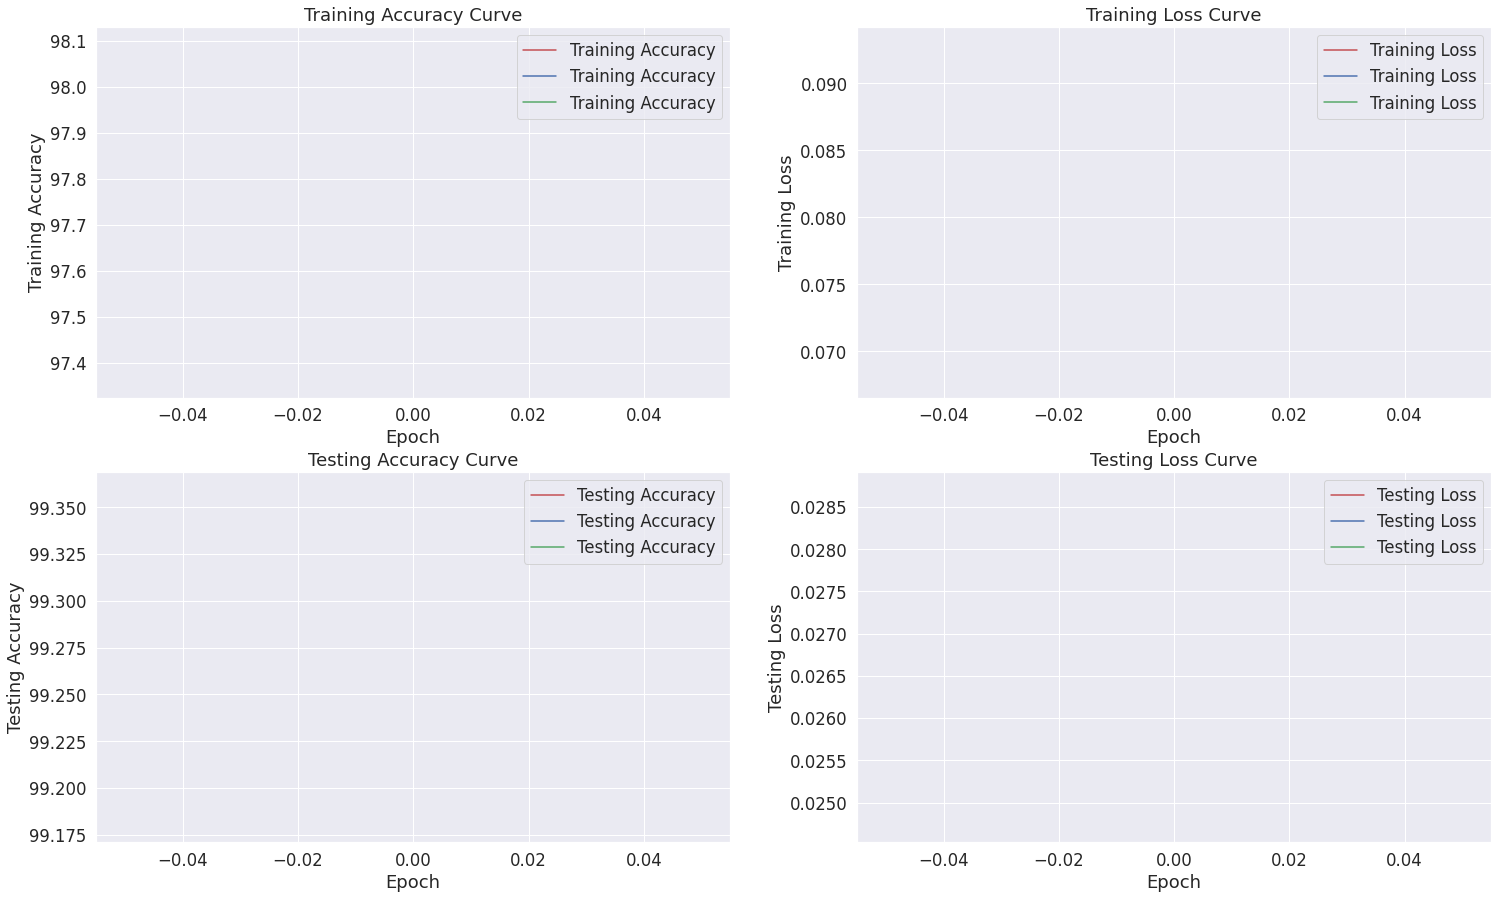

In [16]:
# Plot the learning curve.
fig, axs = plt.subplots(2,2,figsize=(25,15))

# Training Accuracy vs epoch
axs[0, 0].plot(np.array(layer_train_acc), 'r', label="Training Accuracy")
axs[0, 0].plot(np.array(group_train_acc), 'b', label="Training Accuracy")
axs[0, 0].plot(np.array(batch_train_acc), 'g', label="Training Accuracy")
axs[0, 0].set_title("Training Accuracy Curve")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Training Accuracy")
axs[0, 0].legend()

# Training loss vs epoch
axs[0, 1].plot(np.array(layer_train_loss), 'r', label="Training Loss")
axs[0, 1].plot(np.array(group_train_loss), 'b', label="Training Loss")
axs[0, 1].plot(np.array(batch_train_loss), 'g', label="Training Loss")
axs[0, 1].set_title("Training Loss Curve")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Training Loss")
axs[0, 1].legend()

# Testing Accuracy vs epoch
axs[1, 0].plot(np.array(layer_test_acc), 'r', label="Testing Accuracy")
axs[1, 0].plot(np.array(group_test_acc), 'b', label="Testing Accuracy")
axs[1, 0].plot(np.array(batch_test_acc), 'g', label="Testing Accuracy")
axs[1, 0].set_title("Testing Accuracy Curve")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Testing Accuracy")
axs[1, 0].legend()

# Testing loss vs epoch
axs[1, 1].plot(np.array(layer_test_loss), 'r', label="Testing Loss")
axs[1, 1].plot(np.array(group_test_loss), 'b', label="Testing Loss")
axs[1, 1].plot(np.array(batch_test_loss), 'g', label="Testing Loss")
axs[1, 1].set_title("Testing Loss Curve")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Testing Loss")
axs[1, 1].legend()


plt.show()